In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, VotingRegressor
from sklearn.svm import SVR
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import optuna
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import mlflow
from mlflow.tracking import MlflowClient
from math import sqrt

In [2]:
# Load the dataset
df = pd.read_csv('./final-weather-flight-data/processed_dataset_YUL-Flights-Weather.csv')

In [3]:
# Separate features and target variable
X = df.drop('Departure Delay (min)', axis=1)
y = df['Departure Delay (min)']

In [4]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize models
models = {
    'LinearRegression': LinearRegression(),
    'RandomForestRegressor': RandomForestRegressor(n_estimators=100, random_state=42),
    'GradientBoostingRegressor': GradientBoostingRegressor(random_state=42),
    'XGBRegressor': xgb.XGBRegressor(random_state=42),
    'SVR': SVR(),
    'Ensemble': VotingRegressor(
        estimators=[
            ('lr', LinearRegression()),
            ('rf', RandomForestRegressor(n_estimators=100, random_state=42)),
            ('gb', GradientBoostingRegressor(random_state=42)),
            ('xgb', xgb.XGBRegressor(random_state=42)),
            ('svm', SVR())
        ]
    )
}

In [6]:
# Function to evaluate models
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return mse, r2

In [19]:
# Test and validate different models
results = {}
for name, model in models.items():
    mse, r2 = evaluate_model(model, X_train, y_train, X_test, y_test)
    results[name] = {'MSE': mse, 'R2': r2}
    print(f"{name} - MSE: {mse:.2f}, R2: {r2:.2f}")

LinearRegression - MSE: 0.60, R2: 0.01


KeyboardInterrupt: 

In [ ]:
# Define the parameter grid for each model
param_grids = {
    'LinearRegression': {},
    'RandomForestRegressor': {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'GradientBoostingRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 10]
    },
    'XGBRegressor': {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 6, 9]
    },
    'SVR': {
        'C': [0.1, 1, 10],
        'gamma': ['scale', 'auto'],
        'kernel': ['linear', 'rbf']
    }
}

# Function to perform grid search and update the model with best parameters
def grid_search_tuning(model, params, X_train, y_train):
    grid_search = GridSearchCV(model, params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_train, y_train)
    return grid_search.best_estimator_

# Perform grid search for each model
best_models = {}
for name in models:
    if param_grids[name]:  # Only perform grid search if there are parameters to tune
        print(f"Grid searching for {name}")
        best_models[name] = grid_search_tuning(models[name], param_grids[name], X_train, y_train)
    else:
        best_models[name] = models[name]  # For models without parameters, use the default

# Create a super ensemble model with the best models
super_ensemble = VotingRegressor(
    estimators=[(name, model) for name, model in best_models.items()]
)

# Evaluate the super ensemble model
mse, r2 = evaluate_model(super_ensemble, X_train, y_train, X_test, y_test)
print(f"Super Ensemble - MSE: {mse:.2f}, R2: {r2:.2f}")

# Update the models dictionary with the best models
models.update(best_models)

In [ ]:
# Function to perform optuna optimization and update the model with best parameters
def optuna_optimization(model, params, X_train, y_train, n_trials=10):
    def objective(trial):
        # Generate the hyperparameters using the trial object
        hyperparams = {param: trial.suggest_categorical(param, values) for param, values in params.items()}
        estimator = model(**hyperparams)
        score = cross_val_score(estimator, X_train, y_train, n_jobs=-1, cv=5, scoring='neg_mean_squared_error')
        return score.mean()  # Optuna tries to maximize the objective, hence return the mean of the negative MSE

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials)
    return model(**study.best_params)

# Perform optuna optimization for each model
optuna_best_models = {}
for name in models:
    if param_grids[name]:  # Only perform optimization if there are parameters to tune
        print(f"Optuna optimization for {name}")
        optuna_best_models[name] = optuna_optimization(models[name], param_grids[name], X_train, y_train)
    else:
        optuna_best_models[name] = models[name]  # For models without parameters, use the default

# Create a super ensemble model with the optuna optimized models
optuna_super_ensemble = VotingRegressor(
    estimators=[(name, model) for name, model in optuna_best_models.items()]
)

# Evaluate the optuna super ensemble model
optuna_mse, optuna_r2 = evaluate_model(optuna_super_ensemble, X_train, y_train, X_test, y_test)
print(f"Optuna Super Ensemble - MSE: {optuna_mse:.2f}, R2: {optuna_r2:.2f}")

# Update the models dictionary with the optuna optimized models
models.update(optuna_best_models)

In [ ]:
# Visualization pipeline
def plot_feature_importances(model, features):
    n_features = len(features)
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), features)
    plt.xlabel("Feature importance")
    plt.ylabel("Feature")
    plt.ylim(-1, n_features)

In [ ]:
# Plot feature importances for GradientBoostingRegressor 
if 'GradientBoostingRegressor' in models:
    rf_model = models['GradientBoostingRegressor']
    rf_model.fit(X_train, y_train)
    plt.figure(figsize=(10, 8))
    plot_feature_importances(rf_model, X.columns)
    plt.show()

To run the following MLFlow experiment, first run the command to open UI: python.exe -m mlflow ui --port 5000

2024/02/22 21:34:04 INFO mlflow.tracking.fluent: Experiment with name 'Flight_Delay_Prediction_Comparison' does not exist. Creating a new experiment.


Model: LinearRegression
  RMSE: 0.7772006850251975
  R2: 0.013614266196277813


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: RandomForestRegressor
  RMSE: 0.8591629469272553
  R2: -0.20540089859755462


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: GradientBoostingRegressor
  RMSE: 0.7671763264180166
  R2: 0.03889503959289864


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: XGBRegressor
  RMSE: 0.8722737985774024
  R2: -0.24247050428526817


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: SVR
  RMSE: 0.7823099711003673
  R2: 0.0006027172541697157


c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
c:\Users\ethan\AppData\Local\Programs\Python\Python311\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")


Model: Ensemble
  RMSE: 0.7704607182563132
  R2: 0.03064816803472792


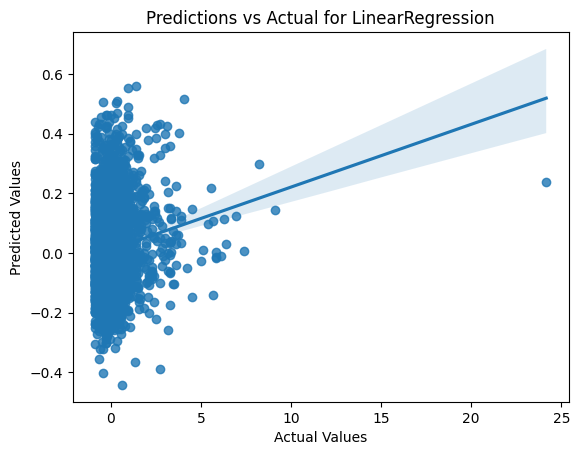

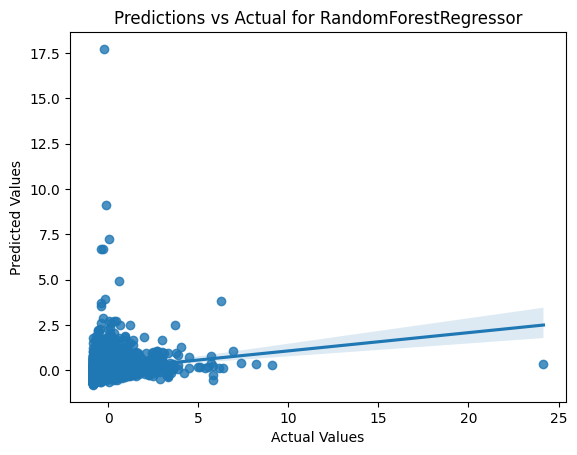

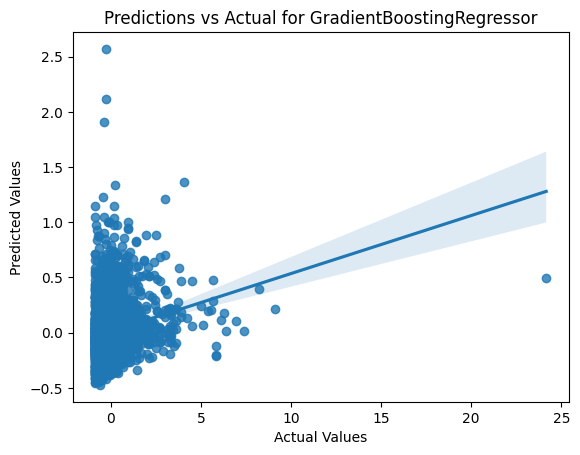

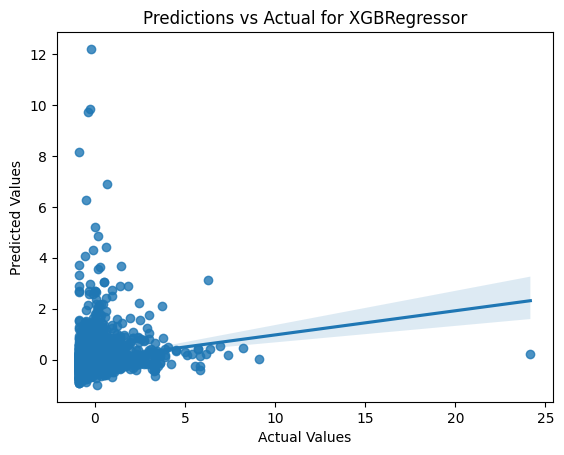

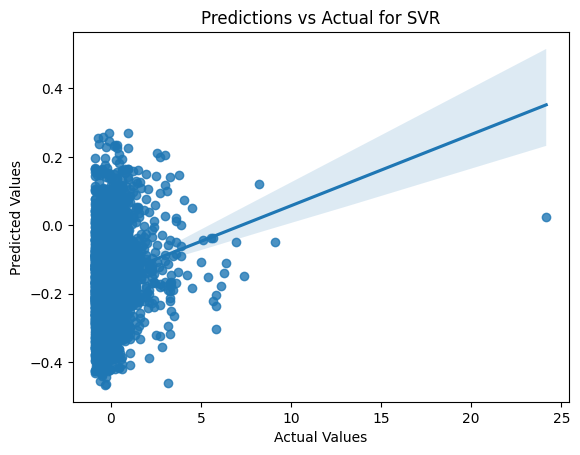

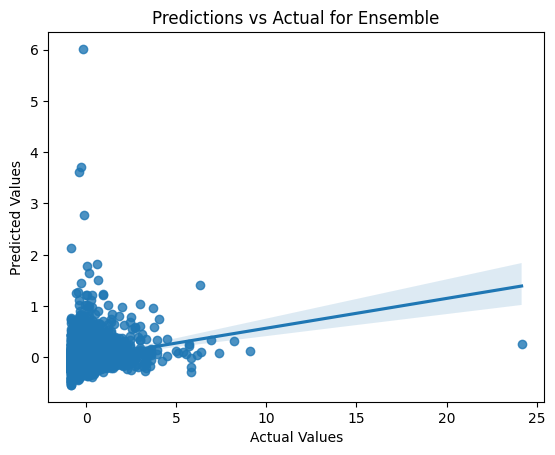

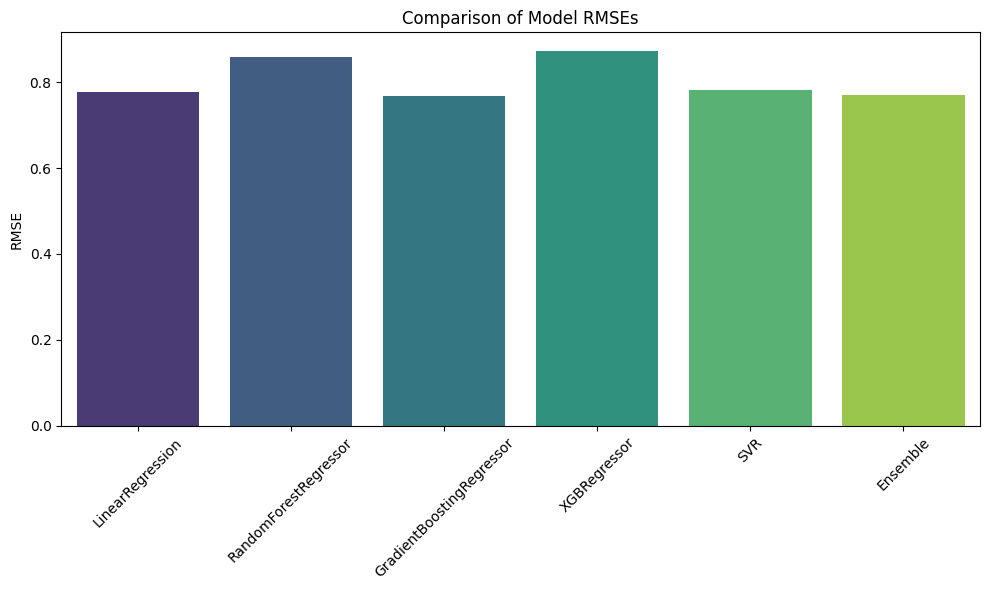

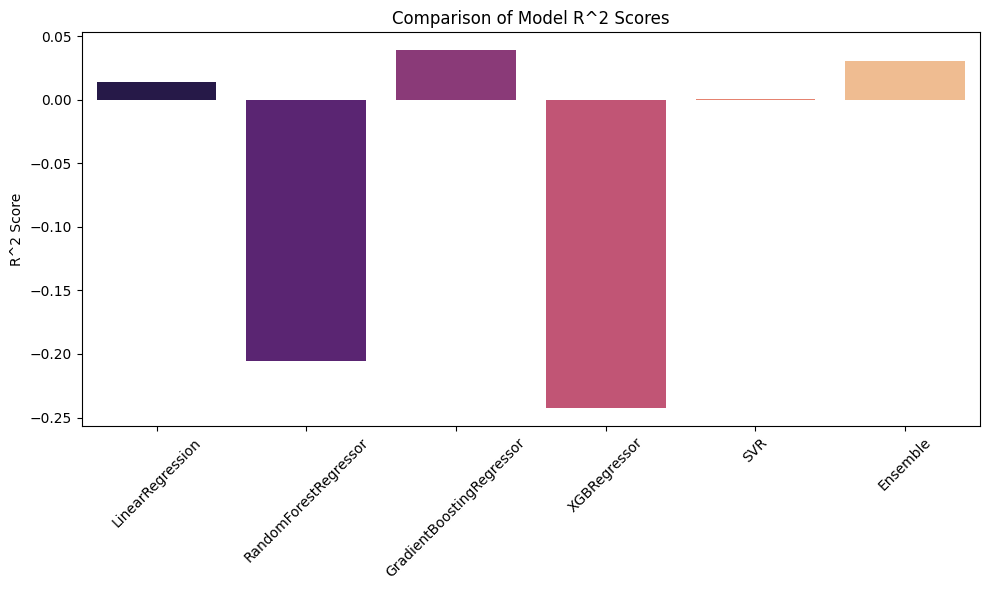

In [7]:
# Function for MLFlow tracking, comparison plotting, and logging evaluation data as a table artifact
def track_model_performance_and_plot(experiment_name, models, X_train, y_train, X_test, y_test):
    """
    Track the model performance using MLFlow, compare all models' RMSE and R^2 metrics with bar charts,
    log evaluation data as a table artifact for each model, and ensure that the MLFlow UI can be accessed.

    Parameters:
    - experiment_name: str, the name of the MLFlow experiment.
    - models: dict, a dictionary of model names and their instances.
    - X_train: training data features.
    - y_train: training data target.
    - X_test: test data features.
    - y_test: test data target.
    """

    # Set the MLFlow experiment
    mlflow.set_experiment(experiment_name)

    # Initialize lists to store RMSE and R^2 for all models
    rmses = []
    r2s = []
    model_names = []
    evaluation_data = []

    # Start MLFlow run
    for model_name, model in models.items():
        with mlflow.start_run():
            # Log model name
            mlflow.log_param("model_name", model_name)

            # Fit the model
            model.fit(X_train, y_train)

            # Make predictions
            predictions = model.predict(X_test)

            # Calculate metrics
            rmse = sqrt(mean_squared_error(y_test, predictions))
            r2 = r2_score(y_test, predictions)

            # Append metrics to lists
            rmses.append(rmse)
            r2s.append(r2)
            model_names.append(model_name)

            # Log metrics
            mlflow.log_metric(f"{model_name}_rmse", float(rmse))
            mlflow.log_metric(f"{model_name}_r2", float(r2))

            # Log model
            mlflow.sklearn.log_model(model, f"{model_name}_model")

            # Print out metrics
            print(f"Model: {model_name}")
            print(f"  RMSE: {rmse}")
            print(f"  R2: {r2}")

            # Create and log figures for predictions vs actual
            fig, ax = plt.subplots()
            sns.regplot(x=y_test, y=predictions, ax=ax)
            ax.set_title(f'Predictions vs Actual for {model_name}')
            ax.set_xlabel('Actual Values')
            ax.set_ylabel('Predicted Values')
            plt.savefig(f"{model_name}_predictions_vs_actual.png")
            mlflow.log_artifact(f"{model_name}_predictions_vs_actual.png")

            # Log evaluation data as a table artifact
            eval_data = {
                'Model Name': model_name,
                'RMSE': rmse,
                'R2': r2
            }
            evaluation_data.append(eval_data)
            eval_df = pd.DataFrame([eval_data])
            eval_df.to_csv(f"{model_name}_evaluation_data.csv", index=False)
            mlflow.log_artifact(f"{model_name}_evaluation_data.csv")

            # Set tags
            mlflow.set_tag("developer", "Team 2")

            # End MLFlow run
            mlflow.end_run()

    # Plot comparison of RMSE for all models
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=rmses, palette='viridis')
    plt.title('Comparison of Model RMSEs')
    plt.ylabel('RMSE')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("model_rmse_comparison.png")
    mlflow.log_artifact("model_rmse_comparison.png")

    # Plot comparison of R^2 for all models
    plt.figure(figsize=(10, 6))
    sns.barplot(x=model_names, y=r2s, palette='magma')
    plt.title('Comparison of Model R^2 Scores')
    plt.ylabel('R^2 Score')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig("model_r2_comparison.png")
    mlflow.log_artifact("model_r2_comparison.png")

# Track and log each model's performance using MLFlow and plot comparisons
track_model_performance_and_plot(
    experiment_name="Flight_Delay_Prediction_Comparison",
    models=models,
    X_train=X_train,
    y_train=y_train,
    X_test=X_test,
    y_test=y_test
)